In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import logging
import utils.gpu as gpu
from model.yolov3 import Yolov3
from model.loss.yolo_loss import YoloV3Loss
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
import utils.datasets as data
import time
import random
import argparse
from eval.evaluator import *
from utils.tools import *
from tensorboardX import SummaryWriter
import config.yolov3_config_voc as cfg
from utils import cosine_lr_scheduler
import pandas as pd


# GPU device
# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cuda


# 이미지 비율 조정

In [2]:
import os
import albumentations as A
import cv2
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]= 10, 10

In [3]:
img_path = './data/org_test/' + os.listdir('./data/test/')[0]
img_path

'./data/org_test/5d3fa62be4b0aecb2989e41e.jpg'

In [4]:
org_img = cv2.imread(img_path)
print("shape: ", org_img.shape)

shape:  (8187, 3027, 3)


In [5]:
def read_img(img_path, img_size=416):
    transform = A.Compose([
        A.LongestMaxSize(max_size=img_size, always_apply=True),
        A.PadIfNeeded(img_size, img_size, always_apply=True, border_mode=0, value=[0, 0, 0]),
        ],
    )
    img = cv2.imread(img_path)
    data = transform(image=img)
    
    return data['image']

In [6]:
img = read_img(img_path)
print("shape: ", img.shape)

shape:  (416, 416, 3)


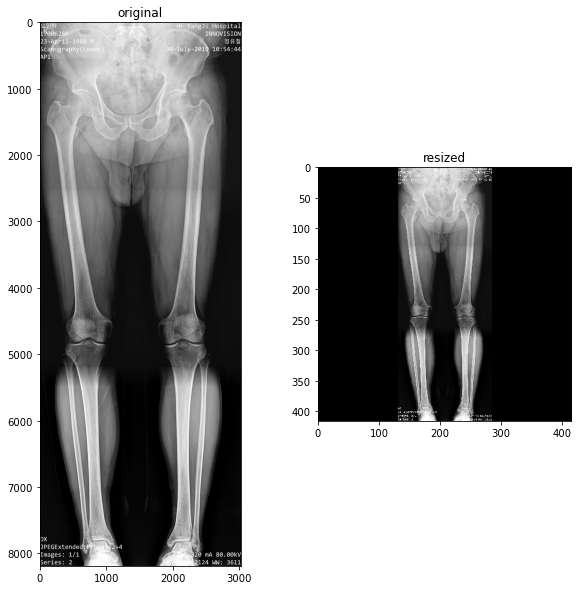

In [7]:
plt.subplot(121)
plt.title("original")
plt.imshow(org_img)

plt.subplot(122)
plt.title("resized")
plt.imshow(img)

plt.show()

In [8]:
org_img.shape, img.shape

((8187, 3027, 3), (416, 416, 3))

In [9]:
def get_ratio(org_img_shape, img_shape):
    '''
    org_img_shape: (h,w,c)
    img_shape: (h,w,c)
    '''
    h_ratio, w_ratio = img_shape[0] / org_img_shape[0], img_shape[1] / org_img_shape[1]
    return h_ratio, w_ratio

In [10]:
get_ratio(org_img.shape, img.shape)

(0.05081226334432637, 0.13742979848034356)

### 이미지 사이즈 조절 과정

원본 --> w또는h가 416이 되도록 리사이즈 --> 남은 부위 padding 추가

In [11]:
img_size = 416

LMS_transform = A.Compose([
        A.LongestMaxSize(max_size=img_size, always_apply=True)
        ])

PIN_transform = A.Compose([
        A.PadIfNeeded(img_size, img_size, always_apply=True, border_mode=0, value=[0, 0, 0])
        ])

./data/org_test/5d3fa62be4b0aecb2989e41e.jpg
shape:  (8187, 3027, 3)
Shape:  (416, 154, 3)
Shape:  (416, 416, 3)


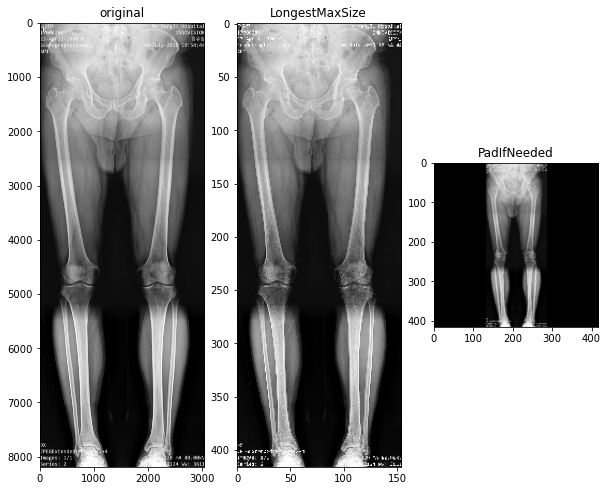

In [12]:
img_path = './data/org_test/' + os.listdir('./data/test/')[0]
print(img_path)

org_img = cv2.imread(img_path)
print("shape: ", org_img.shape)

data = LMS_transform(image=org_img)
LMS_img = data['image']
print("Shape: ", LMS_img.shape)

data = PIN_transform(image=LMS_img)
PIN_img = data['image']
print("Shape: ", PIN_img.shape)

# show image
plt.subplot(131)
plt.title("original")
plt.imshow(org_img)

plt.subplot(132)
plt.title("LongestMaxSize")
plt.imshow(LMS_img)

plt.subplot(133)
plt.title("PadIfNeeded")
plt.imshow(PIN_img)

plt.show()

131
285
Shape:  (416, 154, 3)


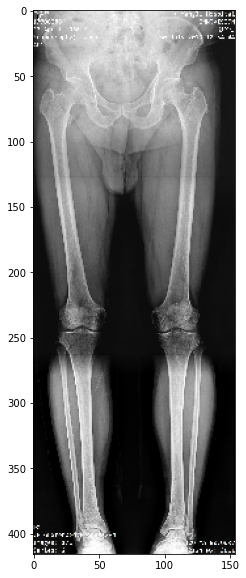

In [13]:
img_size = 416

# print(416 - 154)
# print((416 - 154)//2)

a = (img_size - min(LMS_img.shape[:2]) ) // 2
print(a)

b = a + min(LMS_img.shape[:2])
print(b)

re_PIN_img = PIN_img[:, a:b]
# plt.imshow(PIN_img[:, a:b])
print("Shape: ", re_PIN_img.shape)
plt.imshow(re_PIN_img)
plt.show()

Shape:  (8187, 3027, 3)


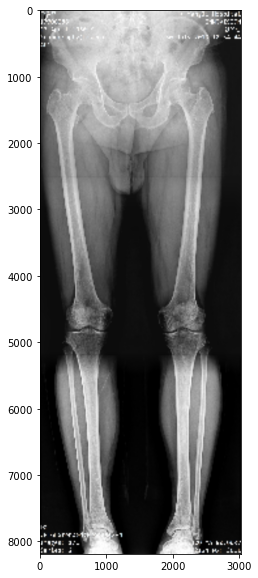

In [14]:
h, w = org_img.shape[0], org_img.shape[1]

re_org_img = cv2.resize(re_PIN_img, (w, h))
print("Shape: ", re_org_img.shape)
plt.imshow(re_org_img)
plt.show()

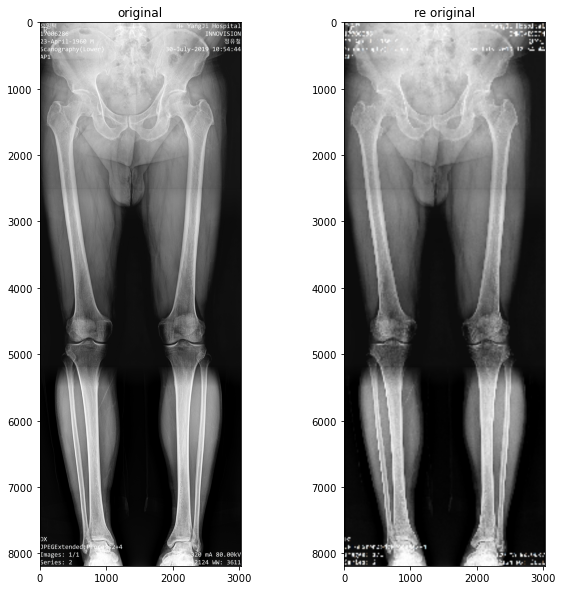

In [15]:
# show image
plt.subplot(121)
plt.title("original")
plt.imshow(org_img)

plt.subplot(122)
plt.title("re original")
plt.imshow(re_org_img)

plt.show()

In [16]:
resized_img = PIN_img

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

import torch
from torchvision import transforms
import albumentations.pytorch
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import time
from torch.utils.data import DataLoader
from model.yolov3 import Yolov3
from utils.tools import *
from eval.evaluator import Evaluator
import config.yolov3_config_voc as cfg
from utils.visualize import *
from tqdm import tqdm


# get cfg
num_class = cfg.DATA["NUM"]
conf_threshold = cfg.TEST["CONF_THRESH"]
nms_threshold = cfg.TEST["NMS_THRESH"]
multi_scale_test = cfg.TEST["MULTI_SCALE_TEST"]
flip_test = cfg.TEST["FLIP_TEST"]
classes = cfg.DATA["CLASSES"]

# Load model
model = Yolov3().to(device)
weight_path = './weight/best.pt'
chkpt = torch.load(weight_path, map_location=device)
model.load_state_dict(chkpt['model'])

<All keys matched successfully>

In [18]:
# predict
bboxes_prd = Evaluator(model).get_bbox(resized_img)

# box 개수 수정
bboxes = []
bboxes_prd = bboxes_prd[bboxes_prd[:, -2].argsort(-1)][::-1]
flag = [0]*len(classes)
for box in bboxes_prd:
    i = int(box[-1])
    if flag[i] == 0:
        flag[i] = 1
        bboxes.append(box.tolist())
bboxes_prd = np.array(bboxes)

if bboxes_prd.shape[0] != 0:
    boxes = bboxes_prd[..., :4]
    class_inds = bboxes_prd[..., 5].astype(np.int32)
    scores = bboxes_prd[..., 4]

    visualize_boxes(image=resized_img, boxes=boxes, labels=class_inds, probs=scores, class_labels=classes)
    
    print(resized_img.shape)

(416, 416, 3)


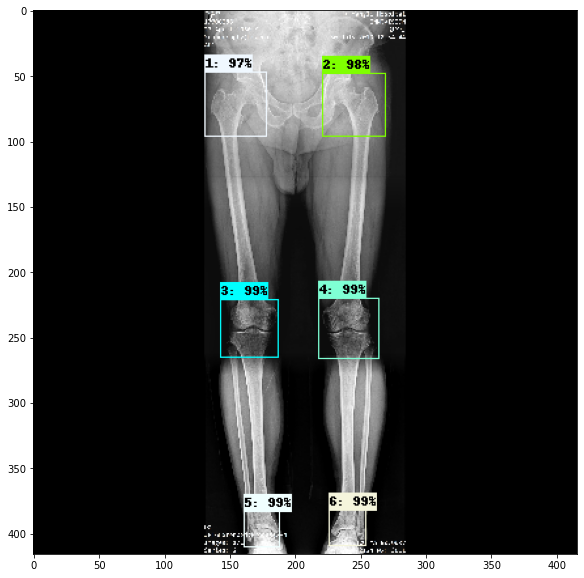

In [19]:
plt.imshow(resized_img)

131 285
Shape:  (416, 154, 3)


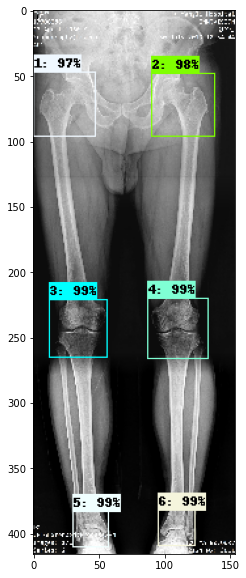

In [20]:
img_size = 416

a = (img_size - min(LMS_img.shape[:2]) ) // 2
b = a + min(LMS_img.shape[:2])
print(a, b)

re_PIN_img = resized_img[:, a:b]

print("Shape: ", re_PIN_img.shape)
plt.imshow(re_PIN_img)
plt.show()

Shape:  (8187, 3027, 3)


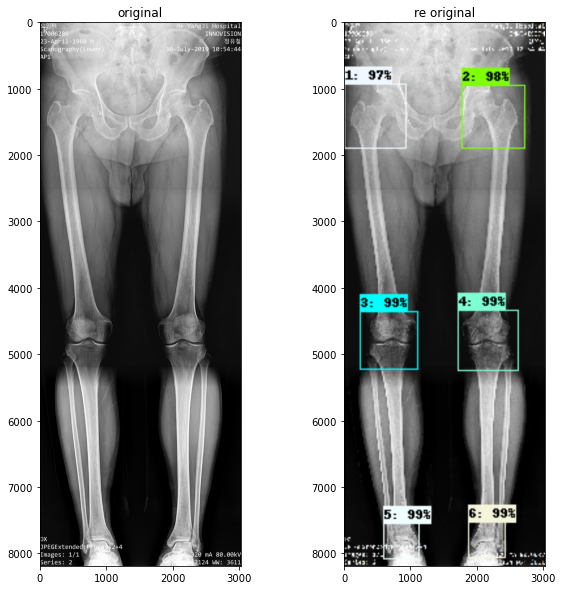

In [21]:
h, w = org_img.shape[0], org_img.shape[1]

re_org_img = cv2.resize(re_PIN_img, (w, h))
print("Shape: ", re_org_img.shape)


# show image
plt.subplot(121)
plt.title("original")
plt.imshow(org_img)

plt.subplot(122)
plt.title("re original")
plt.imshow(re_org_img)

plt.show()

### 문제점

- 이미지를 여러번 resize하면서 해상도나 너무 떨어진다.

Tnink

- 이미지가 아닌 좌표값을 확대 시킨후 원본 이미지에 그냥 박스를 그려보자.

# 좌표값 resize

In [22]:
# 예시 이미지 원본 경로
img_path = './data/org_test/' + os.listdir('./data/test/')[0]
print(img_path)

txt_path = './data/org_test/' + os.listdir('./data/test/')[0].split('.')[0] + '.txt'
print(txt_path)

./data/org_test/5d3fa62be4b0aecb2989e41e.jpg
./data/org_test/5d3fa62be4b0aecb2989e41e.txt


In [24]:
def resize_LMS(org_img, img_size=416):
    '''
    Rescale an image so that maximum side is equal to max_size, keeping the aspect ratio of the initial image.
    '''
    LMS_transform = A.Compose([
        A.LongestMaxSize(max_size=img_size, always_apply=True)
        ])
    data = LMS_transform(image=org_img)
    LMS_img = data['image']
    return LMS_img

def resize_PIN(LMS_img, img_size=416):
    '''
    Pad side of the image / max if side is less than desired number.
    '''
    PIN_transform = A.Compose([
        A.PadIfNeeded(img_size, img_size, always_apply=True, border_mode=0, value=[0, 0, 0])
        ])
    data = PIN_transform(image=LMS_img)
    resized_img = data['image']
    return resized_img

def resize_416(org_path, img_size=416):
    org_img = cv2.imread(org_path)
    print("original img: ", org_img.shape)
    
    LMS_img = resize_LMS(org_img, img_size=416)
    print("LMS img: ", LMS_img.shape)
    
    resized_img = resize_PIN(LMS_img, img_size=416)
    print("resized_img: ", resized_img.shape)
    
    return resized_img

In [25]:
img = resize_416(img_path)

original img:  (8187, 3027, 3)
LMS img:  (416, 154, 3)
resized_img:  (416, 416, 3)


./data/org_test/5d3fa62be4b0aecb2989e41e.jpg
(8187, 3027, 3)
(416, 154, 3)
(416, 416, 3)


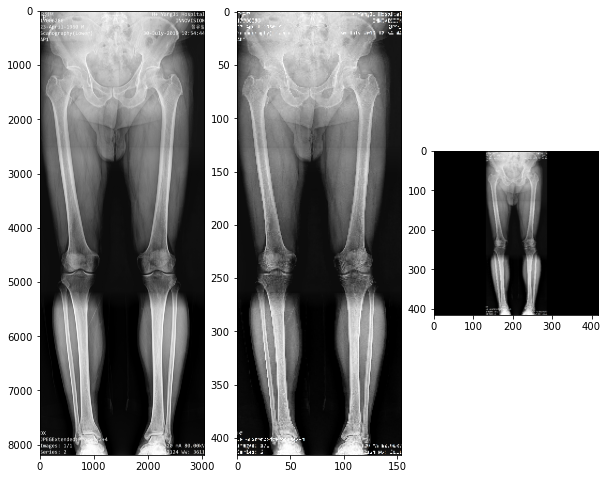

In [26]:
print(img_path)
org_img = cv2.imread(img_path)
print(org_img.shape)
plt.subplot(131)
plt.imshow(org_img)

LMS_img = resize_LMS(org_img)
print(LMS_img.shape)
plt.subplot(132)
plt.imshow(LMS_img)

resized_img = resize_PIN(LMS_img)
print(resized_img.shape)
plt.subplot(133)
plt.imshow(resized_img)

plt.show()

In [27]:
# predict
bboxes_prd = Evaluator(model).get_bbox(resized_img)

# box 개수 수정
bboxes = []
bboxes_prd = bboxes_prd[bboxes_prd[:, -2].argsort(-1)][::-1]
flag = [0]*len(classes)
for box in bboxes_prd:
    i = int(box[-1])
    if flag[i] == 0:
        flag[i] = 1
        bboxes.append(box.tolist())
        
bboxes_prd = np.array(bboxes)

if bboxes_prd.shape[0] != 0:
    boxes = bboxes_prd[..., :4]
    class_inds = bboxes_prd[..., 5].astype(np.int32)
    scores = bboxes_prd[..., 4]

    pred_img = visualize_boxes(image=resized_img, boxes=boxes, labels=class_inds, probs=scores, class_labels=classes)
    
    print(pred_img.shape)

(416, 416, 3)


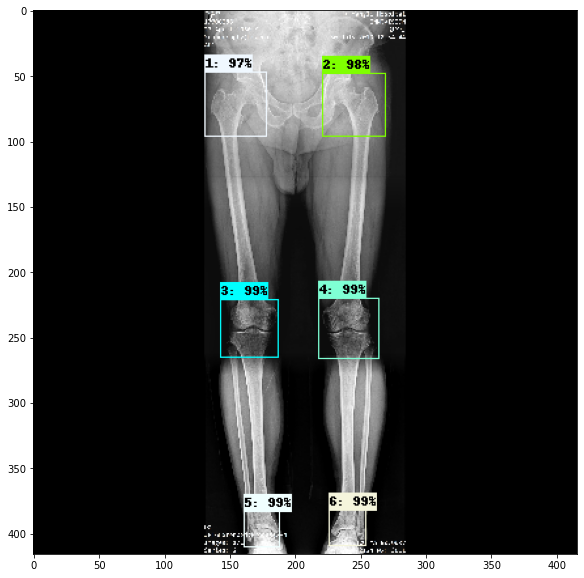

In [29]:
plt.imshow(pred_img)

In [30]:
# check
print(img_path)
print(org_img.shape)
print(LMS_img.shape)
print(resized_img.shape)

./data/org_test/5d3fa62be4b0aecb2989e41e.jpg
(8187, 3027, 3)
(416, 154, 3)
(416, 416, 3)


In [33]:
def func(resized_img, bboxes, org_img_shape, LMS_img_shape):
    # find coordinates
    # resized img --> orinal size img
    
    # 잘라낼 사이즈 계산
    crop_x = (resized_img.shape[1] - LMS_img.shape[1]) // 2 
    
    # x 좌표 수정
    bboxes[:, 0:3:2] = bboxes[:, 0:3:2] - crop_x
    
    # padding 제거된 이미지
    re_crop_img = resized_img[:, crop_x:416-crop_x]
    
    transform = A.Compose([
        A.Resize(org_img_shape[0], org_img_shape[1])],
        bbox_params=A.BboxParams(format='pascal_voc'),
    )

    data = transform(image=re_crop_img, bboxes=bboxes)
    
    return data['bboxes']

./data/org_test/5d3fa62be4b0aecb2989e41e.jpg
(8187, 3027, 3)
(416, 154, 3)
(416, 416, 3)


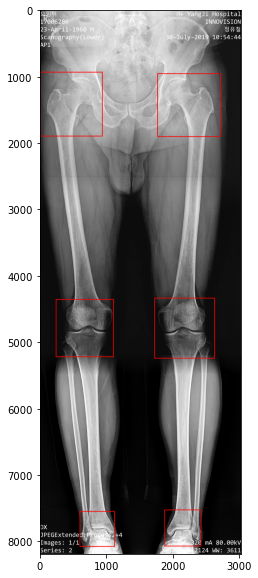

In [35]:
# read image and resize
print(img_path)
org_img = cv2.imread(img_path)

print(org_img.shape)

LMS_img = resize_LMS(org_img)
print(LMS_img.shape)

resized_img = resize_PIN(LMS_img)
print(resized_img.shape)

# predict
bboxes_prd = Evaluator(model).get_bbox(resized_img)

# box 개수 수정
bboxes = []
bboxes_prd = bboxes_prd[bboxes_prd[:, -2].argsort(-1)][::-1]
flag = [0]*len(classes)
for box in bboxes_prd:
    i = int(box[-1])
    if flag[i] == 0:
        flag[i] = 1
        bboxes.append(box.tolist())
bboxes = np.array(bboxes)

# coordinates resize to original
boxes = func(resized_img, bboxes, org_img.shape, LMS_img.shape)

for i in range(len(boxes)):
    box = list(map(int, boxes[i]))
    org_img = cv2.rectangle(org_img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 9)

plt.imshow(org_img)
plt.show()

### 원본이랑 비교

In [36]:
df = pd.read_csv(txt_path)
df

,class,center_x,center_y,w,h,angle
0,1,500,1410,920,920,0
1,2,2210,1410,940,940,0
2,3,690,4790,900,900,0
3,4,2180,4800,920,920,0
4,5,870,7820,580,580,0
5,6,2170,7870,600,600,0


In [37]:
# bounding box 좌표 변경하기
def cvt_coordinate(center_x, center_y, w, h):
    '''
    start_x, start_y: 시작 꼭짓점 좌표 (x, y)
    end_x, end_y: 종료 꼭짓점 좌표 (x, y)
    '''
    start_x, end_x = center_x - (w//2), center_x + (w//2)
    start_y, end_y = center_y - (h//2), center_y + (h//2)

    return str(start_x), str(start_y), str(end_x), str(end_y)

In [38]:
data = []
for j in range(6):
    val = df.iloc[j].tolist()
    center_x, center_y, w, h = val[1], val[2], val[3], val[4]
    start_x, start_y, end_x, end_y = cvt_coordinate(center_x, center_y, w, h)
    coordinate = [start_x, start_y, end_x, end_y, str(val[0])]        
    data.append(coordinate)

In [39]:
data

[['40', '950', '960', '1870', '1'],
 ['1740', '940', '2680', '1880', '2'],
 ['240', '4340', '1140', '5240', '3'],
 ['1720', '4340', '2640', '5260', '4'],
 ['580', '7530', '1160', '8110', '5'],
 ['1870', '7570', '2470', '8170', '6']]

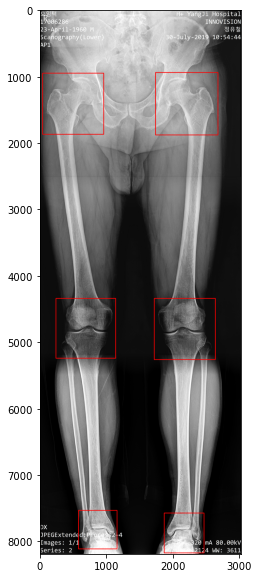

In [40]:
img = cv2.imread(img_path)

for i in range(len(data)):
    box = list(map(int, data[i]))
    img = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 9)

plt.imshow(img)